In [1]:
import sys
import numpy as np
sys.path.insert(1, r'C:\Users\shams\PhD\segmentation\arild\river-segmentation\source')
sys.path.insert(1, r'C:\Users\shams\PhD\segmentation\scripts\preprocess')
import model_utils
from rotation_function import *

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
color_dict = {
    # color code : rgb
    # water is blue
    0: [0, 0, 1],
    # gravel is yellow
    1: [1, 1, 0],
    # vegetation is green
    2: [0, 1, 0],
    # farmland is brown
    3: [1, 0, 1],
    # construction is red
    4: [1, 0, 0],
    # unknown is white
    5: [1, 1, 1]
}

# gives us rgb for each label
def show_label_elm(label_elm, index):
    return np.array(color_dict[label_elm])[index]

# vectorizing the function
show_vec = np.vectorize(show_label_elm)

# get the rgb array for label
def get_colored_label(label, max_dim=3):
    label_color_arr = np.zeros((*label.shape,3))
    for i in range(max_dim):
        label_color_arr[...,i] = show_vec(label, i)
    return label_color_arr

In [10]:
def rotation_augmentation_func(rotation_angle_list, image_number_lim, river_name, large_image_folder_path,
                               large_label_folder_path, save_folder_base, saving_mode='png', method='skimage',
                               small_image_size=512, selection_lim=2000, selected_class=1,
                               labeled_percentage_val=0.9, overlap_percentage_val=0.5, rotation_noise=0,
                               replace_unknown=True, ):
    for image_number in range(0, image_number_lim):
        # get the file path of image and corresponding label
        image_filepath, label_filepath = get_img_lbl_pair(large_image_folder_path, large_label_folder_path, river_name,
                                                          image_number)
        # get the name of large image to add to csv file
        large_image_file_name = os.path.basename(os.path.normpath(image_filepath))
        print(f'working on image number={image_number}, name={large_image_file_name}')
        # read the image and label
        image_matrix, label_matrix, geo_transform, projection = get_images(image_filepath, label_filepath)

        # swap the 0 and 5 because it is easier when we rotate it
#         label_matrix_changed = label_matrix
        label_matrix_changed = vectorised_swap(label_matrix)

        image_list, label_list, csv_list, masked_large, overlap_large = get_augment_rotate_double(
            image_matrix, label_matrix_changed,
            small_image_size, selection_lim,
            selected_class, rotation_angle_list,
            large_image_file_name, method=method,
            labeled_percentage=labeled_percentage_val,
            overlap_percentage=overlap_percentage_val,
            rotation_noise=rotation_noise,
        )
        
        if image_list:
            fig, ax = plt.subplots(2, 2)
            fig.suptitle('before')
            ax[0, 0].imshow(image_list[0], cmap='gray')
            ax[0, 1].imshow(get_colored_label(label_list[0]))

            ax[1, 0].imshow(image_list[1], cmap='gray')
            ax[1, 1].imshow(get_colored_label(label_list[1]))
            plt.show()
    
        # if image is not good enough
        if not image_list:
            print(f'image {large_image_file_name} is not useful')
            continue

        # change the labels back to normal
        for idx in range(len(label_list)):
            label_list[idx] = vectorised_swap(label_list[idx])

        # make folders to save results
        save_folder_image = os.path.join(save_folder_base, river_name, f'image_{method}')
        save_folder_label = os.path.join(save_folder_base, river_name, f'label_{method}')
        make_folder(save_folder_image)
        make_folder(save_folder_label)

        # save image and label
        if saving_mode == 'gis':
            print('gis mode of saving')
#             save_augmented_list(label_list, save_folder_label, large_image_file_name, geo_transform, projection)
#             save_augmented_list(image_list, save_folder_image, large_image_file_name, geo_transform, projection)

        else:
            print('png mode of saving')
            # replace 5 with NN
            if replace_unknown:
                label_list = np.stack(label_list, axis=0)
                label_list = model_utils.replace_class(label_list, class_id=5)
            image_list = np.stack(image_list, axis=0)
            # add fake data to it
            image_list = np.stack([image_list, image_list, image_list], axis=3)
            print(f'the shape of image and label {image_list.shape} {label_list.shape}')
            # analysing the results
            image_class_df = get_class_analysis(label_list, class_name_dict)
            # save image
#             save_augmented_np_png(label_list, save_folder_label, large_image_file_name)
#             save_augmented_np_png(image_list, save_folder_image, large_image_file_name)

        if True:
            fig, ax = plt.subplots(2, 2)
            fig.suptitle('after')
            ax[0, 0].imshow(image_list[0,:,:,0], cmap='gray')
            ax[0, 1].imshow(get_colored_label(label_list[0]))

            ax[1, 0].imshow(image_list[1])
            ax[1, 1].imshow(get_colored_label(label_list[1]))
            plt.show()

        # save csvs
        csv_address = os.path.join(save_folder_label, large_image_file_name)
        pd.DataFrame(csv_list).to_csv(f'{csv_address}.csv', index=False)
#         image_class_df.to_csv(f'{csv_address}_class.csv', index=False)


working on image number=0, name=33-2-462-207-23.tif
image 33-2-462-207-23.tif is not useful
working on image number=1, name=33-2-462-207-32.tif
x shape is 1146560 so the number of selection will be 2239
there were 2220 not useful images here
there were 19 useful images here


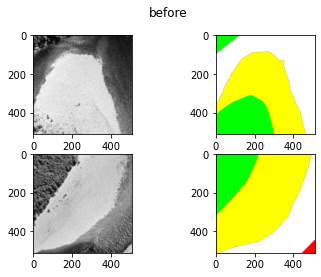

png mode of saving
the shape of image and label (19, 512, 512, 3) (19, 512, 512)


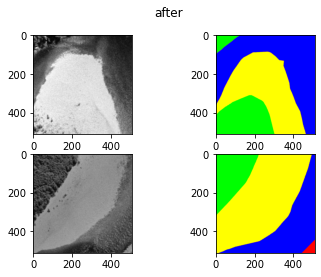

working on image number=2, name=33-2-462-207-33.tif
x shape is 2490390 so the number of selection will be 4864
there were 4825 not useful images here
there were 39 useful images here


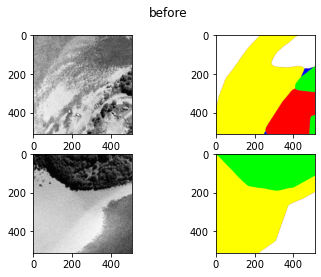

png mode of saving
the shape of image and label (39, 512, 512, 3) (39, 512, 512)


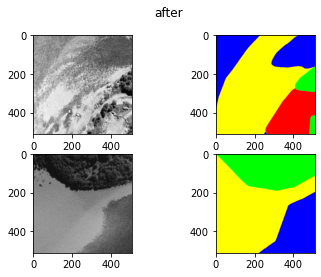

working on image number=3, name=33-2-462-208-13.tif
image 33-2-462-208-13.tif is not useful
working on image number=4, name=33-2-462-208-20.tif
image 33-2-462-208-20.tif is not useful
working on image number=5, name=33-2-462-208-21.tif
image 33-2-462-208-21.tif is not useful
working on image number=6, name=33-2-462-208-22.tif
image 33-2-462-208-22.tif is not useful
working on image number=7, name=33-2-462-208-23.tif
x shape is 672978 so the number of selection will be 2000
there were 1969 not useful images here
there were 31 useful images here


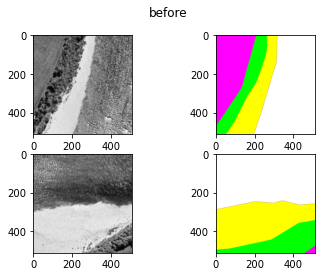

png mode of saving
the shape of image and label (31, 512, 512, 3) (31, 512, 512)


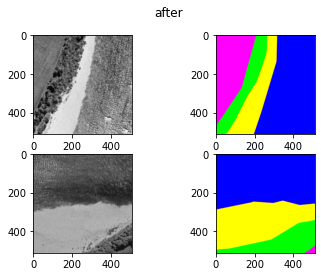

working on image number=8, name=33-2-462-208-30.tif
x shape is 2717961 so the number of selection will be 5308
there were 5269 not useful images here
there were 39 useful images here


KeyboardInterrupt: 

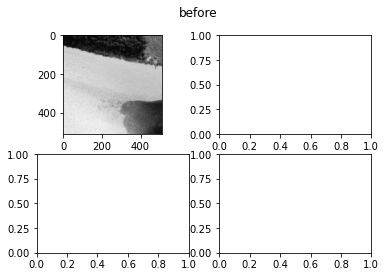

In [11]:
# method can only be scipy or skimage
method = 'skimage'
# saving mode can be 'gis' or 'png'
saving_mode = 'png'
large_image_folder_path = r'C:\Users\shams\PhD\segmentation\dataset\large_gis\image'
large_label_folder_path = r'C:\Users\shams\PhD\segmentation\dataset\large_gis\label'
river_name = 'gaula_1963'
small_image_size = 512
selection_lim = 2000
# list of all rotations
rotation_angle_list = [127]
# percentage for not unknown class
labeled_percentage_val = 0.9
# threshold for not having overlap
overlap_percentage_val = 0.5
replace_unknown = True
image_number_lim = get_number_tif_files(large_label_folder_path, river_name)

image_list_val, lebel_list_val = rotation_augmentation_func(rotation_angle_list, 
                                                            image_number_lim , river_name, large_image_folder_path, large_label_folder_path,
                                                            save_folder_base='', saving_mode='png', method='skimage',
                                                            small_image_size=512, selection_lim=2000, selected_class=1,
                                                            labeled_percentage_val=0.9, overlap_percentage_val=0.5, rotation_noise=0,
                                                            replace_unknown=True, )

In [ ]:
image_list_val